# Caso Práctico Random Forest
En este caso de uso practico se pretende resolver un problema de deteccion de malware en dispositivos Android mediante el análisis que el tráfico de red que genera el dispositivo mediante el uso de conjuntos de árboles de desición.

### Deteccion de Malware en Android

#### Descripción

// Pegar aqui lo de WhatsApp

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
from pandas import DataFrame


## Funciones Auxiliares

In [2]:
## Construcción de una funcion que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [3]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return(X, y)

In [4]:
def evaluate_resul(y_pred, y, y_prep_pred, y_prep, metric):
    print(metric.__name__, "WITHOUT preparation", metric(y_pred, y, average='weighted'))
    print(metric.__name__, "WITH preparation", metric(y_prep_pred, y_prep, average='weighted'))
    


## 1.- Lectura del DataSet

In [5]:
df = pd.read_csv('datasets/datasets/TotalFeatures-ISCXFlowMeter.csv')

## 2.- Visualización del DataSet

In [6]:
df.head(10)

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
0,1020586,668,1641,35692,2276876,52,52,679,1390,53.431138,...,0.0,-1,0.0,2,4194240,1853440,1640,668,32,benign
1,80794,1,1,75,124,75,124,75,124,75.000000,...,0.0,-1,0.0,2,0,0,0,1,0,benign
2,998,3,0,187,0,52,-1,83,-1,62.333333,...,0.0,-1,0.0,4,101888,-1,0,3,32,benign
3,189868,9,9,1448,6200,52,52,706,1390,160.888889,...,0.0,-1,0.0,2,4194240,2722560,8,9,32,benign
4,110577,4,6,528,1422,52,52,331,1005,132.000000,...,0.0,-1,0.0,2,155136,31232,5,4,32,benign
5,261876,7,6,1618,882,52,52,730,477,231.142857,...,0.0,-1,0.0,2,4194240,926720,3,7,32,benign
6,14,2,0,104,0,52,-1,52,-1,52.000000,...,0.0,-1,0.0,3,5824,-1,0,2,32,benign
7,29675,1,1,71,213,71,213,71,213,71.000000,...,0.0,-1,0.0,2,0,0,0,1,0,benign
8,806635,4,0,239,0,52,-1,83,-1,59.750000,...,0.0,-1,0.0,5,107008,-1,0,4,32,benign
9,56620,3,2,1074,719,52,52,592,667,358.000000,...,0.0,-1,0.0,3,128512,10816,1,3,32,benign


In [7]:
df.describe()

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
count,6.319550e+05,631955.000000,631955.000000,6.319550e+05,6.319550e+05,631955.000000,631955.000000,631955.000000,631955.000000,631955.000000,...,6.319550e+05,6.319550e+05,6.319550e+05,6.319550e+05,631955.000000,6.319550e+05,6.319550e+05,631955.000000,631955.00000,631955.000000
mean,2.195245e+07,6.728514,10.431934,9.540172e+02,1.206042e+04,141.475727,44.357688,263.675901,183.248084,174.959706,...,1.997327e+07,2.031228e+07,2.075238e+07,4.663875e+05,2.360896,9.620796e+05,3.104519e+05,9.733144,6.72471,19.965713
std,1.900578e+08,174.161354,349.424019,8.235040e+04,4.824716e+05,157.680880,89.099554,289.644383,371.863224,162.024811,...,1.897986e+08,1.897902e+08,1.899721e+08,6.199704e+06,3.041810,1.705655e+06,6.647956e+05,347.877923,174.13813,14.914261
min,-1.800000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,-1.000000e+00,-1.000000e+00,0.000000,0.00000,0.000000
25%,0.000000e+00,1.000000,0.000000,6.900000e+01,0.000000e+00,52.000000,-1.000000,52.000000,-1.000000,52.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,0.000000e+00,-1.000000e+00,0.000000,1.00000,0.000000
50%,2.445000e+04,1.000000,0.000000,1.840000e+02,0.000000e+00,52.000000,-1.000000,83.000000,-1.000000,83.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,8.761600e+04,-1.000000e+00,0.000000,1.00000,32.000000
75%,1.759751e+06,3.000000,1.000000,4.270000e+02,1.670000e+02,108.000000,52.000000,421.000000,115.000000,356.000000,...,1.013498e+06,1.291379e+06,1.306116e+06,0.000000e+00,2.000000,3.046400e+05,9.049600e+04,1.000000,3.00000,32.000000
max,4.431076e+10,48255.000000,74768.000000,4.049644e+07,1.039222e+08,1390.000000,1390.000000,1500.000000,1390.000000,1390.000000,...,4.431072e+10,4.430000e+10,4.431072e+10,8.470000e+08,2269.000000,4.194240e+06,4.194240e+06,74524.000000,48255.00000,44.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631955 entries, 0 to 631954
Data columns (total 80 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration                 631955 non-null  int64  
 1   total_fpackets           631955 non-null  int64  
 2   total_bpackets           631955 non-null  int64  
 3   total_fpktl              631955 non-null  int64  
 4   total_bpktl              631955 non-null  int64  
 5   min_fpktl                631955 non-null  int64  
 6   min_bpktl                631955 non-null  int64  
 7   max_fpktl                631955 non-null  int64  
 8   max_bpktl                631955 non-null  int64  
 9   mean_fpktl               631955 non-null  float64
 10  mean_bpktl               631955 non-null  float64
 11  std_fpktl                631955 non-null  float64
 12  std_bpktl                631955 non-null  float64
 13  total_fiat               631955 non-null  int64  
 14  tota

In [9]:
print("Longitud del DataSet", len(df))
print("Numero de caracteristicas del DataSet", len(df.columns))

Longitud del DataSet 631955
Numero de caracteristicas del DataSet 80


In [10]:
df['calss'].value_counts()

calss
benign            471597
asware            155613
GeneralMalware      4745
Name: count, dtype: int64

#### Buscando correlaciones

In [11]:
# Transformar la variable de salida a numerica para calcular correlaciones

X = df.copy()
X['calss'] = X['calss'].factorize()[0]
corr_matrix = X.corr()
corr_matrix['calss'].sort_values(ascending=False)

calss                     1.000000
flow_fin                  0.286175
min_seg_size_forward      0.258352
Init_Win_bytes_forward    0.129425
std_fpktl                 0.123758
                            ...   
furg_cnt                       NaN
burg_cnt                       NaN
flow_urg                       NaN
flow_cwr                       NaN
flow_ece                       NaN
Name: calss, Length: 80, dtype: float64

In [12]:
X.corr()

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
duration,1.000000,0.004837,0.004011,0.001673,0.003518,-0.064100,-0.027231,0.008761,0.042925,-0.043746,...,0.998901,0.999458,0.047582,0.016532,0.027610,0.029712,0.003785,0.004838,0.082955,0.067066
total_fpackets,0.004837,1.000000,0.924622,0.425756,0.904007,-0.018958,0.005252,0.024685,0.086255,-0.007910,...,0.001614,0.002267,0.017229,0.016089,0.050201,0.059224,0.902713,0.999866,0.018198,0.018377
total_bpackets,0.004011,0.924622,1.000000,0.156780,0.997268,-0.017667,0.006912,0.018170,0.086886,-0.016104,...,0.000922,0.001617,0.016230,-0.000493,0.048190,0.058435,0.997580,0.924746,0.015124,0.019430
total_fpktl,0.001673,0.425756,0.156780,1.000000,0.090082,-0.003099,0.000803,0.021278,0.022088,0.022409,...,0.000335,0.000609,0.009896,0.001657,0.013283,0.015991,0.088422,0.425789,0.005477,0.000679
total_bpktl,0.003518,0.904007,0.997268,0.090082,1.000000,-0.014926,0.005966,0.012560,0.079905,-0.017328,...,0.000812,0.001452,0.014336,-0.000293,0.043571,0.053134,0.999616,0.904129,0.012139,0.019838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Init_Win_bytes_backward,0.029712,0.059224,0.058435,0.015991,0.053134,-0.268444,0.038319,0.429893,0.593143,-0.030004,...,0.026959,0.029512,0.097316,-0.052507,0.811204,1.000000,0.056761,0.059242,0.333701,0.069405
RRT_samples_clnt,0.003785,0.902713,0.997580,0.088422,0.999616,-0.016659,0.006156,0.015727,0.084280,-0.017595,...,0.000893,0.001560,0.015200,-0.000437,0.046784,0.056761,1.000000,0.902834,0.014299,0.019679
Act_data_pkt_forward,0.004838,0.999866,0.924746,0.425789,0.904129,-0.018947,0.005264,0.024705,0.086278,-0.007893,...,0.001617,0.002269,0.017233,0.000734,0.050220,0.059242,0.902834,1.000000,0.018229,0.018391
min_seg_size_forward,0.082955,0.018198,0.015124,0.005477,0.012139,-0.686154,-0.189824,-0.074763,0.217989,-0.524024,...,0.077943,0.079324,0.048803,0.052177,0.394743,0.333701,0.014299,0.018229,1.000000,0.258352


Se puede llegar a valorar quedarse con aquellas que tienen mayor correlación

In [13]:
corr_matrix[corr_matrix["calss"]>0.05]

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
duration,1.000000,0.004837,0.004011,0.001673,0.003518,-0.064100,-0.027231,0.008761,0.042925,-0.043746,...,0.998901,0.999458,0.047582,0.016532,0.027610,0.029712,0.003785,0.004838,0.082955,0.067066
max_bpktl,0.042925,0.086255,0.086886,0.022088,0.079905,-0.277317,0.275923,0.492194,1.000000,-0.018358,...,0.035413,0.038732,0.127548,-0.044916,0.586742,0.593143,0.084280,0.086278,0.217989,0.073212
mean_bpktl,0.025117,0.139142,0.151761,0.018954,0.146437,-0.280648,0.465208,0.342392,0.895712,-0.096195,...,0.018533,0.021519,0.114949,-0.045442,0.452735,0.478823,0.150252,0.139172,0.122226,0.064753
std_fpktl,0.039350,0.010172,0.002331,0.011416,-0.003162,-0.245792,0.052877,0.817873,0.564243,0.259588,...,0.031418,0.033978,0.096844,-0.020885,0.558249,0.532900,0.000140,0.010182,0.301237,0.123758
std_bpktl,0.048743,0.020324,0.014005,0.007763,0.007768,-0.225143,0.035371,0.534532,0.941626,0.051756,...,0.042562,0.045450,0.113854,-0.033991,0.594790,0.577954,0.012050,0.020335,0.276055,0.072953
total_fiat,0.943898,0.002190,0.001718,0.000708,0.001546,-0.049879,-0.031218,-0.029233,-0.005961,-0.048869,...,0.943668,0.943339,0.015254,0.020302,-0.011637,-0.016421,0.001615,0.002190,0.065124,0.064770
min_fiat,0.841692,-0.001975,-0.002172,-0.000746,-0.001820,-0.040046,-0.036619,-0.052289,-0.035963,-0.053811,...,0.843330,0.842512,-0.005389,0.015316,-0.027350,-0.033944,-0.002037,-0.001974,0.051853,0.074491
max_fiat,0.943438,-0.000420,-0.000714,-0.000389,-0.000548,-0.046977,-0.032630,-0.032606,-0.009878,-0.049032,...,0.944412,0.943971,0.012557,0.017756,-0.012317,-0.016206,-0.000644,-0.000418,0.061285,0.064875
mean_fiat,0.918036,-0.001970,-0.002241,-0.000728,-0.001907,-0.042455,-0.036056,-0.048712,-0.032412,-0.052892,...,0.919653,0.918797,-0.003523,0.016958,-0.025823,-0.032466,-0.002113,-0.001968,0.055151,0.071397
std_flowpktl,0.036942,0.087741,0.087307,0.024298,0.080666,-0.262968,0.338513,0.631466,0.911584,0.095976,...,0.030013,0.033100,0.120257,-0.035737,0.580266,0.586355,0.084725,0.087764,0.219346,0.119375


## 3.- División del DataSet

In [14]:
# División del DataSet

train_set, val_set, test_set = train_val_test_split(X)

In [15]:
X_train, y_train = remove_labels(train_set, 'calss')
X_val, y_val = remove_labels(val_set, 'calss')
X_test, y_test = remove_labels(test_set, 'calss')

## 4.- Escalado del DataSet

Es importante comprender que los árboles de desicion son algoritmos que **No requieren demasiada preparación de los datos** concretamente, no requieren la realización o escalado o normalización. En este ejercicio se va a realizar escaldo al DataSet y se van a comparar los resultados con el DataSet si  escalar. De esta manera se demuestra como aplicar preprocesamientos de como el escalado puede llegar afectar al rendimiento del modelo.

In [16]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [17]:
scaler = RobustScaler()
X_test_scaled = scaler.fit_transform(X_test)

In [18]:
scaler = RobustScaler()
X_val_scaled = scaler.fit_transform(X_val)

In [19]:
# TRasformacion del DataSet a un DataFrame de pandas

X_train_scaled = DataFrame(X_train_scaled, columns= X_train.columns, index = X_train.index)
X_train_scaled.head(10)

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
508881,-0.013646,0.0,1.0,-0.310056,1.556886,0.375000,4.924528,-0.027100,2.250000,-0.032895,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000011,0.0,0.0,-1.0
208326,-0.013926,0.0,0.0,0.664804,0.000000,6.607143,0.000000,0.918699,0.000000,1.115132,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
107213,-0.013926,0.0,0.0,0.703911,0.000000,6.857143,0.000000,0.956640,0.000000,1.161184,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
466726,-0.000273,0.0,1.0,-0.363128,2.724551,0.035714,8.603774,-0.078591,3.931034,-0.095395,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000011,0.0,0.0,-1.0
230085,-0.013926,0.0,0.0,0.664804,0.000000,6.607143,0.000000,0.918699,0.000000,1.115132,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
472961,34.421927,1.5,4.0,1.558659,3.868263,0.000000,1.000000,1.341463,4.163793,0.337171,...,59.657102,48.116772,47.580946,0.0,0.0,13.421042,12.657580,3.0,1.5,0.0
482372,-0.013805,0.5,0.0,-0.136872,0.000000,0.000000,0.000000,0.000000,0.000000,-0.050987,...,0.000000,0.000000,0.000000,0.0,1.0,-0.080736,0.000000,0.0,0.5,0.0
619993,17.578734,0.5,0.0,-0.050279,0.000000,0.553571,0.000000,0.000000,0.000000,0.000000,...,30.549478,24.617883,24.365465,0.0,1.0,0.063376,0.000000,0.0,0.5,0.0
65344,-0.013926,0.0,0.0,0.703911,0.000000,6.857143,0.000000,0.956640,0.000000,1.161184,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
46666,-0.013926,0.0,0.0,0.505587,0.000000,5.589286,0.000000,0.764228,0.000000,0.927632,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0


In [20]:
X_train_scaled.describe()

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
count,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,...,379173.000000,379173.000000,379173.000000,3.791730e+05,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000
mean,12.543409,2.927643,10.762678,1.947184,75.104138,1.600682,0.855241,0.491724,1.591823,0.303639,...,19.838596,16.279309,16.441899,4.686618e+05,0.362658,2.861506,3.435883,10.087709,2.924548,-0.376798
std,116.165117,92.319402,370.875546,185.549801,3071.968461,2.817301,1.676098,0.786500,3.210186,0.533388,...,201.477623,162.562856,160.822696,6.188642e+06,3.836035,5.577212,7.354164,369.660712,92.301146,0.466297
min,-0.013936,-0.500000,0.000000,-0.513966,0.000000,-0.946429,0.000000,-0.227642,0.000000,-0.273026,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-0.286345,0.000000,0.000000,-0.500000,-1.000000
25%,-0.013926,0.000000,0.000000,-0.321229,0.000000,0.000000,0.000000,-0.084011,0.000000,-0.101974,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-0.286342,0.000000,0.000000,0.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.986074,1.000000,1.000000,0.678771,1.000000,1.000000,1.000000,0.915989,1.000000,0.898026,...,1.000000,1.000000,1.000000,0.000000e+00,0.000000,0.713658,1.000000,1.000000,1.000000,0.000000
max,25277.128872,24127.000000,74768.000000,113118.041899,622288.473054,23.892857,26.245283,3.840108,11.991379,4.299342,...,43893.471528,35408.189283,35008.286082,5.670000e+08,2267.000000,13.421042,46.346741,74524.000000,24127.000000,0.375000


## 5.- Decisión Forest

In [21]:
# MOdelo entrenado con el DataSet sin escalar
from sklearn.tree import DecisionTreeClassifier

# Modelo entrenado con el DataSet sin escalar
clf_tree = DecisionTreeClassifier(random_state=42)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [22]:
y_train_pred = clf_tree.predict(X_train)

In [23]:
print("F1 Score Train Set" , f1_score(y_train, y_train_pred, average='weighted'))

F1 Score Train Set 0.9809746378930977


In [24]:
# Predecir con el DataSetde validacion

y_val_pred = clf_tree.predict(X_val)
print("F1 Score Validation Set", f1_score(y_val_pred, y_val, average='weighted'))

F1 Score Validation Set 0.930949443129607


## 6.- Random Forest

In [25]:
# Predecir el conjunto de datos de entrenamiento

y_train_pred = clf_tree.predict(X_train)
y_train_prep_pred = clf_tree.predict(X_train_scaled)

In [26]:
# Comparamos resultados entre escalado y sin escalar
evaluate_resul(y_train_pred, y_train, y_train_prep_pred, y_train, f1_score)

f1_score WITHOUT preparation 0.9812695092376319
f1_score WITH preparation 0.8037651244760387


In [27]:
# Predecimos con el conjunto de datos de validación
y_pred = clf_tree.predict(X_val)
y_prep_pred = clf_tree.predict(X_val_scaled)

/home/uriel/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [28]:
# Comparamos resultados entre escalado y sin escalar
evaluate_resul(y_pred, y_val, y_prep_pred, y_val, f1_score)

f1_score WITHOUT preparation 0.930949443129607
f1_score WITH preparation 0.8056364928422594


## 7.- Regresión Forest

Los arboles y conjuntos de desicion tambien pueden aplicarse a problemas de regresion

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Usamos los mismos datos que para el árbol de decisión para clasificación
reg = RandomForestRegressor( n_estimators=10, random_state=42)
reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [30]:
# Predecimos con el conjunto de datos de validación
y_pred_reg = reg.predict(X_val)

In [31]:
# Comparamos resultados
print(f"Mean Squared Error (MSE): {mean_squared_error(y_val, y_pred_reg)}")

Mean Squared Error (MSE): 0.05844130927817204


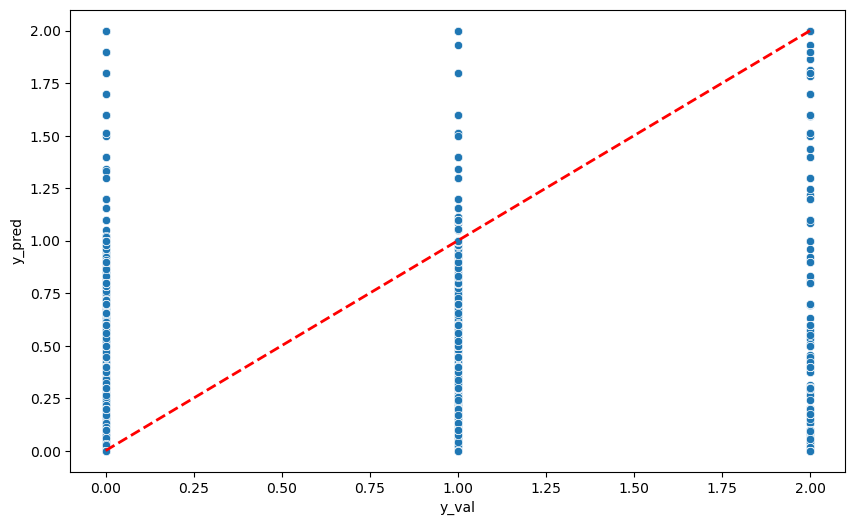

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración del gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val, y=y_pred_reg)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('y_val')
plt.ylabel('y_pred')
plt.grid(False)
plt.show()

In [ ]:
# CÓDIGO FINAL DE LA CELDA EN TU NOTEBOOK (SIN GRÁFICO)

import pandas as pd
import json
from sklearn.metrics import f1_score
from pathlib import Path
# Ya no necesitamos matplotlib ni base64
# import matplotlib.pyplot as plt
# import base64
# from io import BytesIO

# --------------------------------------------------------
# 🛑 PASO CRÍTICO: EDITA ESTA LÍNEA CON LA RUTA ABSOLUTA DE TU PROYECTO
# --------------------------------------------------------
# Asegúrate de usar la ruta a la carpeta que contiene 'manage.py'
RUTA_RAIZ_DJANGO = Path('C:/Users/TuUsuario/Documentos/TuProyecto/MalwareProject') # <-- ¡MODIFICAR ESTA RUTA!
# --------------------------------------------------------
FINAL_FILE_PATH = RUTA_RAIZ_DJANGO / 'final_model_results.json'

try:
    # --------------------------------------------------------
    # 0. GENERACIÓN DE PREDICCIÓN
    # --------------------------------------------------------
    y_train_pred = clf_tree.predict(X_train)

    # --------------------------------------------------------
    # 1. CAPTURA DE RESULTADOS
    # --------------------------------------------------------
    general_info = {
        "Longitud_Total": len(df),
        "Num_Caracteristicas": len(df.columns),
        "Conteo_Clases": df['calss'].value_counts().to_dict(),
        "Descripcion_Numerica": df.describe().to_dict(orient='index')
    }

    corr_target = X.corr()['calss'].sort_values(ascending=False).to_dict()
    scaled_head = X_train_scaled.head(10).to_dict(orient='records')
    scaled_describe = X_train_scaled.describe().to_dict(orient='index')

    feature_importance = pd.Series(clf_tree.feature_importances_, index=X_train.columns)
    importance_df_json = feature_importance.sort_values(ascending=False).head(20).reset_index()
    importance_df_json.columns = ['Feature', 'Importance']

    f1_train_score = f1_score(y_train, y_train_pred, average='weighted')

    # --------------------------------------------------------
    # 2. CONSOLIDAR Y GUARDAR EN JSON
    # --------------------------------------------------------

    final_results = {
        "General_Info": general_info,
        "F1_Score_Train": f1_train_score, 
        "Corr_Target": corr_target,
        "Scaled_Head": scaled_head,
        "Scaled_Describe": scaled_describe,
        "Feature_Importance": importance_df_json.to_dict(orient='records'),
        # Eliminado: "Feature_Graph_Base64"
    }

    # GUARDA USANDO LA RUTA ABSOLUTA
    with open(FINAL_FILE_PATH, 'w') as f:
        json.dump(final_results, f, indent=4)

    print(f"\n✅ ¡ARCHIVO GENERADO CON ÉXITO! Sin gráfico en el JSON.")
    print(f"Búscalo en la ruta: {FINAL_FILE_PATH}")

except NameError as e:
    print(f"\n❌ ERROR DE VARIABLE FALTANTE (NameError): {e}")
    print("\n👉 SOLUCIÓN: Verifica que la celda que define esta variable se haya ejecutado.")
except Exception as e:
    print(f"\n❌ ERROR CRÍTICO AL GENERAR EL JSON: {e}")